In [313]:
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import re
import requests
import seaborn as sns

from db import create_connection
from db import (
    articles,
    services,
    urls
)

In [314]:
connection = create_connection()

# Get data

In [315]:
data = articles.get_articles(connection)

In [316]:
pd.set_option('max_colwidth', 100)
df = pd.DataFrame(data, columns = ['publication_date',
                                   'author',
                                   'title',
                                   'url',
                                   'koronawirus_in_text',
                                   'koronawirus_in_title'])

In [317]:
df.sample(frac = 0.002)

,publication_date,author,title,url,koronawirus_in_text,koronawirus_in_title
2055,NaT,None,None,https://www.se.pl/lublin/chelm-znecali-sie-nad-dziecmi-aa-92iQ-QXwX-DaLS.html,NaN,NaN
7682,NaT,None,None,https://www.se.pl/lublin/lublin-zrodelka-z-woda-w-szkolach-zobacz-12-nowych-lokalizacji-aa-SVJD-...,NaN,NaN
5391,NaT,None,None,https://www.se.pl/lublin/tragiczna-noc-zginal-28-latek-ktory-stracil-panowanie-nad-samochodem-aa...,NaN,NaN
4080,NaT,None,None,https://www.se.pl/lublin/noc-kultury-2018-top-10-subiektywny-przeglad-wydarzen-i-instalacji-prog...,NaN,NaN
4164,NaT,None,None,https://www.se.pl/lublin/masa-zatrzymany-swiadek-koronny-wyludzal-kredyty-aa-vR6s-oL2m-wZpt.html,NaN,NaN
5799,NaT,None,None,https://www.se.pl/lublin/wielka-mobilizacja-mieszkancow-lsm-nie-pozwola-na-zniszczenie-placu-zab...,NaN,NaN
767,2020-02-25 14:57:00,mt,Lublin: Sąsiedzi zobaczyli dym… PIJANA MATKA mogła spowodować KATASTROFĘ,https://www.se.pl/lublin/lublin-sasiedzi-zobaczyli-dym-pijana-matka-mogla-spowodowac-katastrofe-...,0.0,0.0
6541,NaT,None,None,https://www.se.pl/lublin/jarmark-jagiellonski-2016-w-lublinie-w-weekend-12-14-sierpnia-program-l...,NaN,NaN
3012,NaT,None,None,https://www.se.pl/lublin/sa-pieniadze-na-nowe-biznesy-dofinansowanie-mozna-dostac-jeszcze-w-tym-...,NaN,NaN
1631,NaT,None,None,https://www.se.pl/lublin/17-i-18-latek-przelecieli-przez-maske-samochodu-wypadek-zarejestrowala-...,NaN,NaN


# Clean data

### initial data check, organize and clearing

In [318]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8393 entries, 0 to 8392
Data columns (total 6 columns):
publication_date        1489 non-null datetime64[ns]
author                  1489 non-null object
title                   1489 non-null object
url                     8393 non-null object
koronawirus_in_text     1489 non-null float64
koronawirus_in_title    1489 non-null float64
dtypes: datetime64[ns](1), float64(2), object(3)
memory usage: 2.3 MB


In [319]:
df.nunique()

publication_date        1479
author                   124
title                   1486
url                     8393
koronawirus_in_text       33
koronawirus_in_title       2
dtype: int64

In [320]:
df.dropna(inplace=True)
df.shape

(1489, 6)

In [364]:
df['author'] = df['author'].astype('category')
df['koronawirus_in_text'] = df['koronawirus_in_text'].astype('int')
df['koronawirus_in_title'] = df['koronawirus_in_title'].astype('int')
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1489 entries, 0 to 8392
Data columns (total 9 columns):
publication_date        1489 non-null datetime64[ns]
publication_month       1489 non-null object
publication_day         1489 non-null object
author                  1489 non-null category
title                   1489 non-null object
url                     1489 non-null object
koronawirus_in_text     1489 non-null int64
koronawirus_in_title    1489 non-null int64
koronawirus_anywhere    1489 non-null int64
dtypes: category(1), datetime64[ns](1), int64(3), object(4)
memory usage: 855.3 KB


In [322]:
df.count()

publication_date        1489
author                  1489
title                   1489
url                     1489
koronawirus_in_text     1489
koronawirus_in_title    1489
dtype: int64

### column: publication_day

In [323]:
df.insert(loc=1, column='publication_day', value=df['publication_date'].dt.strftime('%Y-%m-%d'))
df.sample(frac = 0.002)

,publication_date,publication_day,author,title,url,koronawirus_in_text,koronawirus_in_title
738,2020-03-10 07:59:00,2020-03-10,mt,Koronawirus w Lubelskiem? ZNAMY WYNIKI pacjentów w szpitalach [AKTUALIZACJA],https://www.se.pl/lublin/koronawirus-w-lubelskiem-piec-osob-w-szpitalach-trwaja-kwarantanny-rapo...,21,1
429,2020-06-16 11:45:00,2020-06-16,Mgorecki,Lublin: Ukradli ponad 70 tysięcy złotych! Udało się dzięki TEJ metodzie [WIDEO],https://lublin.se.pl/lbulin-ukradli-ponad-70-tysiecy-zlotych-udalo-sie-dzieki-tej-poularnej-meto...,0,0
69,2020-08-04 09:05:00,2020-08-04,Karolina Januszek,"Dariusz Stasiak, oświadczenie majątkowe. Jest urzędnikiem zarabia więcej niż prezydent",https://lublin.se.pl/dyrektor-w-urzedzie-gminy-zarabia-wiecej-niz-prezydent-szokujace-oswiadczen...,2,0


In [324]:
df.publication_day.value_counts().head()

2020-06-29    28
2020-07-08    26
2020-07-01    25
2020-07-03    22
2020-07-09    21
Name: publication_day, dtype: int64

In [325]:
df['publication_day'].nunique()

219

In [326]:
#df['publication_day'] = df['publication_day'].astype('category')
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1489 entries, 0 to 8392
Data columns (total 7 columns):
publication_date        1489 non-null datetime64[ns]
publication_day         1489 non-null object
author                  1489 non-null object
title                   1489 non-null object
url                     1489 non-null object
koronawirus_in_text     1489 non-null int64
koronawirus_in_title    1489 non-null int64
dtypes: datetime64[ns](1), int64(2), object(4)
memory usage: 844.3 KB


### column: publication_month

In [327]:
df.insert(loc=1, column='publication_month', value=df['publication_date'].dt.strftime('%Y-%m'))
df.sample(frac = 0.001)

,publication_date,publication_month,publication_day,author,title,url,koronawirus_in_text,koronawirus_in_title
7975,2020-07-10 14:06:00,2020-07,2020-07-10,Maciej Brzeziński,"Wyniki Lotto. Sprawdź wyniki Lotto z 10.07.2020 godz. 14 (Aktualne wygrane, wyniki losowania Mul...",https://lublin.se.pl/wyniki-lotto-sprawdz-wyniki-lotto-z-10-07-2020-godz-14-aktualne-wygrane-wyn...,0,0


In [328]:
df.publication_month.value_counts().head()

2020-07    443
2020-06    214
2020-01    154
2020-05    153
2020-03    147
Name: publication_month, dtype: int64

In [329]:
df['publication_month'].nunique()

8

In [330]:
#df['publication_month'] = df['publication_month'].astype('category')
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1489 entries, 0 to 8392
Data columns (total 8 columns):
publication_date        1489 non-null datetime64[ns]
publication_month       1489 non-null object
publication_day         1489 non-null object
author                  1489 non-null object
title                   1489 non-null object
url                     1489 non-null object
koronawirus_in_text     1489 non-null int64
koronawirus_in_title    1489 non-null int64
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 937.3 KB


### column: author

In [331]:
df['author'].value_counts()[:60]

mt                                 335
Mucha                              147
Marek Targoński                    135
Karolina Januszek                   94
MTA                                 80
Mariusz Mucha                       76
Mucha, mta                          55
AP                                  36
OM                                  32
KM                                  26
Bartłomiej Ważny                    23
Monika Kowalewicz                   22
AC                                  20
Michał Michalak                     16
Mateusz Kasiak                      16
MK                                  16
gk                                  15
Agnieszka Niećko                    15
Jacek Werner                        14
Olka Mazur                          13
Sylwia Sitka-Czerniak               13
Artykuł sponsorowany                13
EIB                                 13
Emilia Białecka                     11
maal                                11
RS                       

In [332]:
df['author'] = df['author'].str.lower()
regex_pattern = re.compile(r'.*mt.*', re.I)
df[df['author'].str.contains(regex_pattern)].count()

publication_date        514
publication_month       514
publication_day         514
author                  514
title                   514
url                     514
koronawirus_in_text     514
koronawirus_in_title    514
dtype: int64

In [333]:
df['author'] = df['author'].replace(['mt', 'mt; wideo: Tygodnik Zamojski', 'gał'],'marek targoński')
# df['author'] = df['author'].replace(['Mucha', 'mucha'],'Mariusz Mucha')
# df['author'] = df['author'].replace(['ŁT'],'Łukasz Trybulski')
# df['author'] = df['author'].replace(['Mateusz Kasiak (Radio Eska)'],'Mateusz Kasiak')
# df['author'] = df['author'].replace(['KaJa'],'Karolina Januszek')
# df['author'] = df['author'].replace(['RS'],'Rafał Strzelec')
# df['author'] = df['author'].replace(['gk'],'Grzegorz Kluczyński')
# df['author'] = df['author'].replace([''],'Nieznany')

# regex_pattern = re.compile(r'(.*,.*|.*/.*|Redakcja ESKA INFO|Nieznany|Akcja partnerska)', re.I)
# df['author'] = df['author'].replace(regex_pattern,'Więcej autorów lub nieznany')

regex_pattern = re.compile(r'.*mt.*', re.I)
df['author'] = df['author'].replace(regex_pattern,'marek targoński')

df['author'].value_counts()[:50]

marek targoński                    651
mucha                              148
karolina januszek                   94
mariusz mucha                       76
ap                                  36
om                                  32
km                                  26
bartłomiej ważny                    23
monika kowalewicz                   22
ac                                  20
maal                                17
mateusz kasiak                      16
michał michalak                     16
mk                                  16
agnieszka niećko                    15
gk                                  15
jacek werner                        14
artykuł sponsorowany                13
sylwia sitka-czerniak               13
eib                                 13
olka mazur                          13
emilia białecka                     11
rs                                  10
kaja                                 9
                                     9
tom                      

In [334]:
df['author'] = df['author'].astype('category')
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1489 entries, 0 to 8392
Data columns (total 8 columns):
publication_date        1489 non-null datetime64[ns]
publication_month       1489 non-null object
publication_day         1489 non-null object
author                  1489 non-null category
title                   1489 non-null object
url                     1489 non-null object
koronawirus_in_text     1489 non-null int64
koronawirus_in_title    1489 non-null int64
dtypes: category(1), datetime64[ns](1), int64(2), object(4)
memory usage: 843.1 KB


### column: koronawiorus_text

In [335]:
# df.loc[[919, 1979, 1965], 'koronawirus_in_text'] = 0

### column: koronawiorus_anywhere_sum

In [369]:
df['koronawirus_anywhere'] = 0
df['koronawirus_anywhere'] = df['koronawirus_in_text'] + df['koronawirus_in_title']
# df.loc[df.koronawirus_anywhere > 0, 'koronawirus_anywhere'] = 1
df.head(1)

,publication_date,publication_month,publication_day,author,title,url,koronawirus_in_text,koronawirus_in_title,koronawirus_anywhere,koronawirus_anywhere_sum
0,2020-08-17 13:40:00,2020-08,2020-08-17,karolina januszek,Wyprawka szkolna 2020. Jak tanio skompletować na nowy rok szkolny?,https://lublin.se.pl/wyprawka-szkolna-2020-jak-tanio-skompletowac-na-nowy-rok-szkolny-ak-fiix-y7...,0,0,0,0


### column: koronawiorus_anywhere_count

In [377]:
df['koronawirus_anywhere_count'] = 0
df['koronawirus_anywhere_count'] = (df['koronawirus_in_text'] + df['koronawirus_in_title']) / (df['koronawirus_in_text'] + df['koronawirus_in_title'])
df

,publication_date,publication_month,publication_day,author,title,url,koronawirus_in_text,koronawirus_in_title,koronawirus_anywhere,koronawirus_anywhere_sum,koronawirus_anywhere_count
0,2020-08-17 13:40:00,2020-08,2020-08-17,karolina januszek,Wyprawka szkolna 2020. Jak tanio skompletować na nowy rok szkolny?,https://lublin.se.pl/wyprawka-szkolna-2020-jak-tanio-skompletowac-na-nowy-rok-szkolny-ak-fiix-y7...,0,0,0,0,NaN
1,2020-08-17 12:30:00,2020-08,2020-08-17,karolina januszek,"Popularna promocja znowu w Lidlu. Zobacz, co możesz kupić",https://lublin.se.pl/popularna-promocja-znowu-w-lidlu-zobacz-co-mozesz-kupic-ak-qjqc-MfwC-D5DE.html,0,0,0,0,NaN
2,2020-08-17 11:54:00,2020-08,2020-08-17,karolina januszek,Uważaj na swoje pieniądze. Oszuści uaktywnili się podczas pandemii,https://lublin.se.pl/uwazaj-na-swoje-pieniadze-oszusci-uaktywnili-sie-podczas-pandemii-ak-2VBF-H...,3,1,4,4,1.0
3,2020-08-17 07:02:00,2020-08,2020-08-17,km,BURZE i wichury do 90 km/h! Prognoza na 17 sierpnia. Sprawdź pogodę na poniedziałek,https://lublin.se.pl/burze-i-wichury-do-90-km-h-prognoza-pogody-16-sierpnia-sprawdz-pogode-na-po...,0,0,0,0,NaN
4,2020-08-15 10:37:00,2020-08,2020-08-15,marek targoński,"Koronawirus w Polsce. Zakażenia: +771, zmarli: +11. Nie żyje 37-letnia kobieta [NOWE DANE]",https://lublin.se.pl/koronawirus-w-polsce-nowe-dane-ministerstwa-zdrowia-kolejna-fala-zakazen-so...,13,1,14,14,1.0
...,...,...,...,...,...,...,...,...,...,...,...
8388,2020-01-03 11:45:00,2020-01,2020-01-03,agnieszka niećko,Lublin: Na autobus poczekamy dłużej. Zarząd Transportu Miejskiego zapowiada zmiany,https://www.se.pl/lublin/na-autobus-poczekamy-dluzej-w-lublinie-zarzad-transportu-miejskiego-zap...,0,0,0,0,NaN
8389,2020-01-03 10:15:00,2020-01,2020-01-03,pt,Lubelskie: Nielegalny ARSENAŁ BRONI pod podłogą w gołębniku!,https://www.se.pl/lublin/lubelskie-nielegalny-arsenal-broni-pod-podloga-w-golebniku-aa-tbwh-J1SU...,0,0,0,0,NaN
8390,2020-01-02 18:00:00,2020-01,2020-01-02,pt,Lublin: ZBOCZENIEC na celowniku policji! Zaatakował na klatce schodowej [PORTRET PAMIĘCIOWY],https://www.se.pl/lublin/lublin-zboczeniec-na-celowniku-policji-zaatakowal-na-klatce-schodowej-p...,0,0,0,0,NaN
8391,2020-01-01 12:39:00,2020-01,2020-01-01,ac,Ptasia grypa SZALEJE na Lubelszczyźnie. Wirus niebezpieczny dla ludzi!,https://www.se.pl/lublin/ptasia-grypa-szaleje-na-lubelszczyznie-wirus-niebezpieczny-dla-ludzi-aa...,3,0,3,3,1.0


# Project

### Pierwsze opublikowane artykuły o covid

In [337]:
covid_articles = df.sort_values(by=['koronawirus_in_title', 'publication_date'], ascending=[False, True])
covid_articles[['publication_date', 'author', 'title', 'url']].head(8)

,publication_date,author,title,url
8337,2020-01-29 15:07:00,mpgt,"Koronawirus na Lubelszczyźnie? Sześć osób trafiło na badania! [AKTUALIZACJA, AUDIO]",https://www.se.pl/lublin/koronawirus-na-lubelszczyznie-lecieli-samolotem-z-pasazerami-z-chin-tra...
8331,2020-01-31 10:46:00,marek targoński,Koronawirus z Chin: Gdzie jest? Sprawdź swój region! Lubelskie jest bezpieczne? [MAPA],https://www.se.pl/lublin/koronawirus-z-chin-gdzie-jest-sprawdz-swoj-region-lubelskie-jest-bezpie...
8324,2020-02-05 16:54:00,ac,Koronawirus w Lublinie? Mężczyzna zgłosił się z do kliniki chorób zakaźnych! [AKTUALIZACJA],https://www.se.pl/lublin/koronawirus-w-lublinie-mezczyzna-zglosil-sie-z-objawami-do-kliniki-chor...
806,2020-02-08 22:25:00,marek targoński,KORONAWIRUS w Lublinie? Znamy wyniki badań! NOWE INFORMACJE [RELACJA],https://www.se.pl/lublin/koronawirus-w-lublinie-pacjent-trafil-do-szpitala-trwaja-badania-audio-...
8296,2020-02-26 09:33:00,marek targoński,Koronawirus w Lubelskiem? Wrócili z Włoch – 27 osób pod lupą sanepidu. „Zwiększone ryzyko” [AKTU...,https://www.se.pl/lublin/koronawirus-w-lubelskiem-wrocili-z-wloch-27-osob-pod-lupa-sanepidu-zwie...
8295,2020-02-26 13:31:00,marek targoński,Koronawirus w Lublinie? Uczelnia zawiesza rekrutację cudzoziemców. „Wszyscy się boimy”,https://www.se.pl/lublin/koronawirus-w-lublinie-uczelnia-zawiesza-rekrutacje-cudzoziemcow-wszysc...
763,2020-02-26 14:58:00,marek targoński,"Koronawirus w Lubelskiem? Dwie osoby w szpitalu! Trwają badania [AKTUALIZACJA, AUDIO]",https://www.se.pl/lublin/koronawirus-na-lubelszczyznie-dwie-osoby-w-szpitalu-trwaja-badania-aa-a...
8294,2020-02-27 07:42:00,marek targoński,Koronawirus. Gdzie zgłosić się z objawami w Lublinie? Oddziały zakaźne w Lubelskiem [ADRESY],https://www.se.pl/lublin/koronawirus-gdzie-zglosic-sie-z-objawami-w-lublinie-oddzialy-zakazne-w-...


### łączna ilość artykułów mających w tytule słowo z grupy "koronawirus"

In [338]:
# df.koronawirus_in_title.sum()

df.groupby('koronawirus_in_title').count()

,publication_date,publication_month,publication_day,author,title,url,koronawirus_in_text,koronawirus_anywhere
koronawirus_in_title,,,,,,,,
0,1138,1138,1138,1138,1138,1138,1138,1138
1,351,351,351,351,351,351,351,351


### średnia ilość artykułów mających w tytule słowo z grupy "koronawirus"

In [339]:
df.koronawirus_in_title.mean()

0.23572867696440564

### Ilość opublikowanych artykułów ze słowem "k" w tytule w każdym miesiącu + porównanie

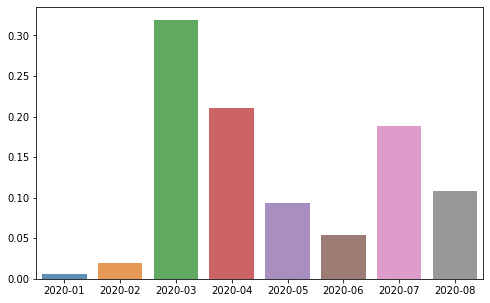

In [340]:
publication_month_with_koronawirus_in_title_count = df_with_koronawirus_in_title.publication_month.astype('category').value_counts(normalize=True)
plt.figure(figsize=(8, 5))
sns.barplot(publication_month_with_koronawirus_in_title_count.index, publication_month_with_koronawirus_in_title_count.values, alpha=0.8)
plt.show()

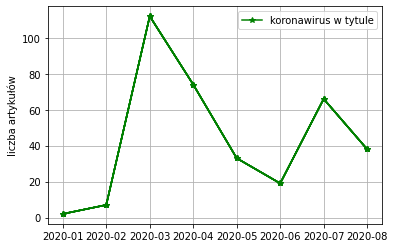

In [341]:
df_with_koronawirus_in_title = df.where(df["koronawirus_in_title"] > 0).dropna()

plt.plot(df_with_koronawirus_in_title.groupby('publication_month').count(),
         color='g',
        marker='*')
plt.ylabel("liczba artykułów")
plt.legend(["koronawirus w tytule"])
plt.grid()
plt.show()

### Łączna ilość artykułów mających w tekście słowo z grupy "koronawirus"

In [342]:
koronawirus_in_text_true = df['koronawirus_in_text'] > 0
df['koronawirus_in_text'][koronawirus_in_text_true].count()

555

In [343]:
koronawirus_in_text_true.mean()

0.37273337810611146

### Ilość opublikowanych artykułów ze słowem "k" w tekście w każdym miesiącu

In [344]:
df_with_koronawirus_in_text = df.where(df["koronawirus_in_text"] > 0).dropna()
df_with_koronawirus_in_text.head(1)

,publication_date,publication_month,publication_day,author,title,url,koronawirus_in_text,koronawirus_in_title,koronawirus_anywhere
2,2020-08-17 11:54:00,2020-08,2020-08-17,karolina januszek,Uważaj na swoje pieniądze. Oszuści uaktywnili się podczas pandemii,https://lublin.se.pl/uwazaj-na-swoje-pieniadze-oszusci-uaktywnili-sie-podczas-pandemii-ak-2VBF-H...,3.0,1.0,4.0


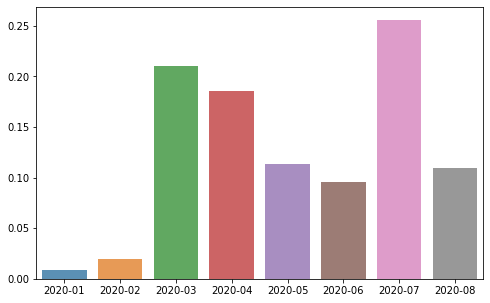

In [345]:
publication_month_with_koronawirus_in_text_count = df_with_koronawirus_in_text.publication_month.astype('category').value_counts(normalize=True)
plt.figure(figsize=(8, 5))
sns.barplot(publication_month_with_koronawirus_in_text_count.index, publication_month_with_koronawirus_in_text_count.values, alpha=0.8)
plt.show()

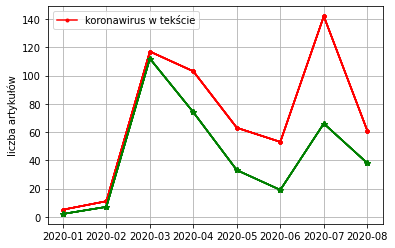

In [346]:
a = plt.plot(df_with_koronawirus_in_text.groupby('publication_month').count(),
        color='r',
        marker='.')

b = plt.plot(df_with_koronawirus_in_title.groupby('publication_month').count(),
        color='g',
        marker='*',
            label='b')

plt.ylabel("liczba artykułów")
plt.grid()
plt.legend(a, ["koronawirus w tekście"])
plt.show()

In [347]:
df_with_koronawirus_in_text.groupby('publication_month').count()

,publication_date,publication_day,author,title,url,koronawirus_in_text,koronawirus_in_title,koronawirus_anywhere
publication_month,,,,,,,,
2020-01,5,5,5,5,5,5,5,5
2020-02,11,11,11,11,11,11,11,11
2020-03,117,117,117,117,117,117,117,117
2020-04,103,103,103,103,103,103,103,103
2020-05,63,63,63,63,63,63,63,63
2020-06,53,53,53,53,53,53,53,53
2020-07,142,142,142,142,142,142,142,142
2020-08,61,61,61,61,61,61,61,61


In [348]:
df_with_koronawirus_in_title.groupby('publication_month').count()

,publication_date,publication_day,author,title,url,koronawirus_in_text,koronawirus_in_title,koronawirus_anywhere
publication_month,,,,,,,,
2020-01,2,2,2,2,2,2,2,2
2020-02,7,7,7,7,7,7,7,7
2020-03,112,112,112,112,112,112,112,112
2020-04,74,74,74,74,74,74,74,74
2020-05,33,33,33,33,33,33,33,33
2020-06,19,19,19,19,19,19,19,19
2020-07,66,66,66,66,66,66,66,66
2020-08,38,38,38,38,38,38,38,38


### Łączna ilość artykułów

In [349]:
df.shape[0]

1489

### Dni z  największą liczbą opublikowanych artykułów

In [350]:
df.publication_day.value_counts().head(3)

2020-06-29    28
2020-07-08    26
2020-07-01    25
Name: publication_day, dtype: int64

### Ilość opublikowanych artykułów w każdym miesiącu

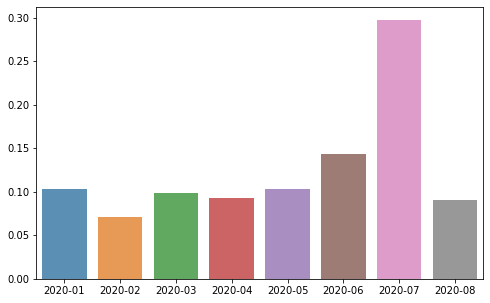

In [351]:
publication_month_count = df.publication_month.astype('category').value_counts(normalize=True)
plt.figure(figsize=(8, 5))
sns.barplot(publication_month_count.index, publication_month_count.values, alpha=0.8)
plt.show()

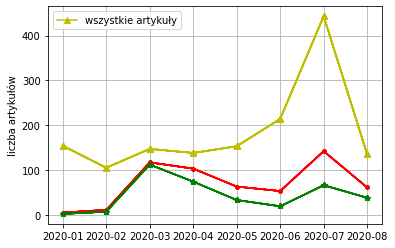

In [352]:
df_with_koronawirus_in_title = df.where(df["koronawirus_in_title"] > 0).dropna()

df_with_koronawirus_in_text = df.where(df["koronawirus_in_text"] > 0).dropna()

c = plt.plot(df.groupby('publication_month').count(),
        color='y',
        marker='^')



a = plt.plot(df_with_koronawirus_in_text.groupby('publication_month').count(),
        color='r',
        marker='.')

b = plt.plot(df_with_koronawirus_in_title.groupby('publication_month').count(),
        color='g',
        marker='*')

plt.ylabel("liczba artykułów")

plt.legend(c, ["wszystkie artykuły"])
plt.grid()
plt.show()

In [353]:
wskaznik = df_with_koronawirus_anywhere.groupby('publication_month').count() / df.groupby('publication_month').count() * 100
wskaznik["publication_date"]

publication_month
2020-01     3.246753
2020-02    10.476190
2020-03    79.591837
2020-04    74.637681
2020-05    41.176471
2020-06    24.766355
2020-07    32.054176
2020-08    45.185185
Name: publication_date, dtype: float64

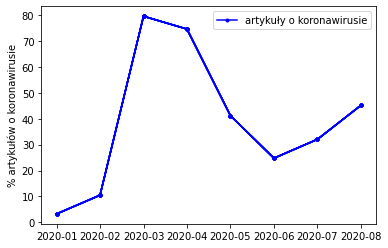

In [354]:

df_with_koronawirus_anywhere = df.where(df["koronawirus_anywhere"] > 0).dropna()

plt.plot((df_with_koronawirus_anywhere.groupby('publication_month').count() / df.groupby('publication_month').count()) * 100,
        color="b",
        marker='.')
plt.ylabel("% artykułów o koronawirusie")
plt.legend(["artykuły o koronawirusie"])

### łączna ilość słów z grupy "koronawirus"

In [355]:
df.koronawirus_in_text.sum()

6152

### średnia ilość słów z grupy "koronawirus" biorąc pod uwagę tematyczne

In [356]:
koronawirus_in_text_true = df['koronawirus_in_text'] > 0
df['koronawirus_in_text'][koronawirus_in_text_true].mean()

11.084684684684685

### Artykuł z największą ilością słów z serii "covid"

In [357]:
# df.loc[df.koronawirus_in_text.idxmax()]

# df['koronawirus_in_text_rank'] = df['koronawirus_in_text'].rank(ascending=False)
# df.sort_values(by='koronawirus_in_text', ascending=False).head(15)

# df.sort_values(by='koronawirus_in_text', ascending=False)[:5]

df.nlargest(n=5, columns='koronawirus_in_text')

,publication_date,publication_month,publication_day,author,title,url,koronawirus_in_text,koronawirus_in_title,koronawirus_anywhere
8206,2020-04-16 22:42:00,2020-04,2020-04-16,paweł tabędzki / marek targoński / sylwia sitka-czerniak / konrad marzec,Przełom w walce z koronawirusem?! ARCYWAŻNE zmiany ogłoszone przez rząd. Koronawirus w Polsce [Z...,https://www.se.pl/lublin/liczba-zgonow-i-zakazonych-rosnie-najnowsze-informacje-oraz-statystyki-...,575,1,576
8224,2020-04-07 07:00:00,2020-04,2020-04-07,"magdalena jaśkiewicz-stawowczyk, marek targoński",Szokujący bilans koronawirusa w Polsce. Ważne słowa prezydenta Dudy. Groza w UK [ZAPIS RELACJI N...,https://www.se.pl/lublin/koronawirus-w-polsce-dzis-niedziela-palmowa-pierwsza-taka-w-historii-ko...,466,1,467
747,2020-03-04 22:25:00,2020-03,2020-03-04,marek targoński,Koronawirus w Polsce! Oto konsekwencje: wzrost cen i wysoki popyt [ZAPIS RELACJI NA ŻYWO],https://www.se.pl/lublin/koronawirus-w-polsce-tytul-relacja-na-zywo-aa-jzM9-R6pH-GAfM.html,325,1,326
709,2020-03-19 09:22:00,2020-03,2020-03-19,marek targoński,Koronawirus Lubelskie: COVID-19 na Lubelszczyźnie. Kto i gdzie choruje? Kim są pacjenci?,https://www.se.pl/lublin/koronawirus-lubelskie-covid-19-na-lubelszczyznie-kto-i-gdzie-choruje-ki...,44,1,45
806,2020-02-08 22:25:00,2020-02,2020-02-08,marek targoński,KORONAWIRUS w Lublinie? Znamy wyniki badań! NOWE INFORMACJE [RELACJA],https://www.se.pl/lublin/koronawirus-w-lublinie-pacjent-trafil-do-szpitala-trwaja-badania-audio-...,29,1,30


### Ilość słów z grupy "koronaworus" w każdym miesiącu

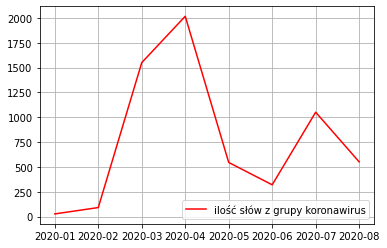

In [358]:
df_with_koronawirus_in_text = df[["koronawirus_in_text", 'publication_month']].where(df["koronawirus_in_text"] > 0).dropna()
df_with_koronawirus_in_text
plt.plot(
    df_with_koronawirus_in_text.groupby('publication_month').sum(),
    color="r",
    label='ilość słów z grupy koronawirus'
)
plt.grid()
plt.legend()

### Autor najwiekszej ilości artykułów ze słowem z grupy "koronawirus" w tytule

In [359]:
df_with_koronawirus_in_title = df.where(df["koronawirus_in_title"] > 0).dropna()
df_with_koronawirus_in_title['author'].value_counts()[:1]

marek targoński    214
Name: author, dtype: int64

### Autor najwiekszej ilości artykułów ze słowem z grupy "koronawirus" w tekście

In [360]:
df_with_koronawirus_in_text = df.where(df["koronawirus_in_text"] > 0).dropna()
df_with_koronawirus_in_text['author'].value_counts()[:1]


marek targoński    278
Name: author, dtype: int64

In [361]:
df.query('author == "marek targoński"').groupby('publication_month').sum()

,koronawirus_in_text,koronawirus_in_title,koronawirus_anywhere
publication_month,,,


In [365]:
mt = df[df['author'].isin(['marek targoński'])]
del mt['koronawirus_in_title']
del mt['koronawirus_in_text']
mt.groupby('publication_month').sum()

,koronawirus_anywhere
publication_month,
2020-01,8
2020-02,92
2020-03,1273
2020-04,804
2020-05,437
2020-06,202
2020-07,576
2020-08,427


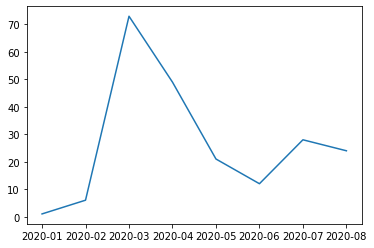

In [378]:
plt.plot(mt.groupby('publication_month').sum())

In [368]:
mt = df[df['author'].isin(['marek targoński'])]
del mt['koronawirus_anywhere']
del mt['koronawirus_in_text']
mt.groupby('publication_month').sum()

,koronawirus_in_title
publication_month,
2020-01,1
2020-02,6
2020-03,73
2020-04,49
2020-05,21
2020-06,12
2020-07,28
2020-08,24


In [ ]:
df['koronawirus_anywhere_count']

In [51]:
df.groupby('publication_month').count()

,publication_date,publication_day,author,title,url,koronawirus_in_text,koronawirus_in_title,koronawirus_anywhere
publication_month,,,,,,,,
2020-01,154,154,154,154,154,154,154,154
2020-02,105,105,105,105,105,105,105,105
2020-03,147,147,147,147,147,147,147,147
2020-04,138,138,138,138,138,138,138,138
2020-05,153,153,153,153,153,153,153,153
2020-06,214,214,214,214,214,214,214,214
2020-07,443,443,443,443,443,443,443,443
2020-08,135,135,135,135,135,135,135,135


In [52]:
# df[koronawirus_in_title_true & ~ koronawirus_in_text_true].head()

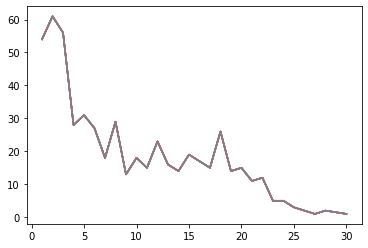

In [53]:
koronawirus_anywhere_true = df['koronawirus_anywhere'] > 0
koronawirus_anywhere_true_count = df.where(koronawirus_anywhere_true).groupby('koronawirus_anywhere').count()[:31]
plt.plot(koronawirus_anywhere_true_count)

In [54]:
koronawirus_anywhere_true_count.sort_values(by='url', ascending=False)

,publication_date,publication_month,publication_day,author,title,url,koronawirus_in_text,koronawirus_in_title
koronawirus_anywhere,,,,,,,,
2.0,61,61,61,61,61,61,61,61
3.0,56,56,56,56,56,56,56,56
1.0,54,54,54,54,54,54,54,54
5.0,31,31,31,31,31,31,31,31
8.0,29,29,29,29,29,29,29,29
4.0,28,28,28,28,28,28,28,28
6.0,27,27,27,27,27,27,27,27
18.0,26,26,26,26,26,26,26,26
12.0,23,23,23,23,23,23,23,23


In [55]:
title_false = df['koronawirus_in_title'] == 0
text_true = df['koronawirus_in_text'] > 0
publication_month_07 = df['publication_month'] == "2020-07"

df_title_false_and_text_true = df[title_false & text_true & publication_month_07]

df_title_false_and_text_true.sort_values(by='koronawirus_in_text', ascending=False)[:50]

,publication_date,publication_month,publication_day,author,title,url,koronawirus_in_text,koronawirus_in_title,koronawirus_anywhere
106,2020-07-28 17:28:00,2020-07,2020-07-28,karolina januszek,Zakaz handlu tymczasowo zniesiony? Jest projekt,https://lublin.se.pl/zakaz-handlu-tymczasowo-zniesiony-jest-projekt-ak-UDmc-xk46-WKyr.html,12,0,12
349,2020-07-01 07:42:00,2020-07,2020-07-01,bartłomiej ważny,"Startuje Słoneczny Wrotków nad Zalewem Zemborzyckim. Sprawdź, co się zmieniło!",https://lublin.se.pl/startuje-sloneczny-wrotkow-nad-zalewem-zemborzyckim-sprawdz-co-sie-zmienilo...,12,0,12
252,2020-07-10 10:01:00,2020-07,2020-07-10,maal,Fundacja Poczty Polskiej pomaga nie tylko pocztowcom,https://lublin.se.pl/fundacja-poczty-polskiej-pomaga-nie-tylko-pocztowcom-ak-mhyB-eDys-5KSt.html,11,0,11
7904,2020-07-24 17:07:00,2020-07,2020-07-24,kaja,Żabka przekazała 3 mln złotych polskim szpitalom. Wszystko dzięki klientom sieci,https://lublin.se.pl/zabka-przekazala-3-mln-zlotych-polskim-szpitalom-wszystko-dzieki-klientom-s...,11,0,11
7983,2020-07-09 18:24:00,2020-07,2020-07-09,maal,Obowiązkowe mierzenie temperatury pracownikom w Polsce! Ministerstwo reaguje,https://lublin.se.pl/obowiazkowe-mierzenie-temperatury-pracownikom-w-polsce-ministerstwo-reaguje...,9,0,9
155,2020-07-22 15:39:00,2020-07,2020-07-22,karolina januszek,Zmiany w zakazie handlu. Jest nowy pomysł,https://lublin.se.pl/zmiany-w-zakazie-handlu-jest-nowy-pomysl-ak-2SVz-XDkR-RuTM.html,6,0,6
179,2020-07-20 13:30:00,2020-07,2020-07-20,karolina januszek,Koniec pracy zdalnej. Jak przygotować firmę na powrót pracowników?,https://lublin.se.pl/koniec-pracy-zdalnej-jak-przygotowac-firme-na-powrot-pracownikow-ak-ftj7-XG...,5,0,5
161,2020-07-22 12:13:00,2020-07,2020-07-22,karolina januszek,Minister Finansów o deficycie. Padła gigantyczna kwota,https://lublin.se.pl/minister-finansow-o-deficycie-padla-gigantyczna-kwota-ak-BwaP-W8ob-8aQ8.html,5,0,5
319,2020-07-03 14:20:00,2020-07,2020-07-03,karolina januszek,Primark w Polsce. Co dalej z otwarciem sklepu w Warszawie?,https://lublin.se.pl/primark-w-polsce-co-dalej-z-otwarciem-sklepu-w-warszawie-ak-7vbs-ADkt-xaho....,5,0,5
8022,2020-07-03 15:34:00,2020-07,2020-07-03,om,Studenci z Lublina zaprojektowali wyjątkowy bolid i wygrali konkurs dla konstruktorów [WIDEO],https://lublin.se.pl/studenci-z-lublina-zaprojektowali-wyjatkowy-bolid-i-wygrali-konkurs-dla-kon...,4,0,4


In [56]:
df

,publication_date,publication_month,publication_day,author,title,url,koronawirus_in_text,koronawirus_in_title,koronawirus_anywhere
0,2020-08-17 13:40:00,2020-08,2020-08-17,karolina januszek,Wyprawka szkolna 2020. Jak tanio skompletować na nowy rok szkolny?,https://lublin.se.pl/wyprawka-szkolna-2020-jak-tanio-skompletowac-na-nowy-rok-szkolny-ak-fiix-y7...,0,0,0
1,2020-08-17 12:30:00,2020-08,2020-08-17,karolina januszek,"Popularna promocja znowu w Lidlu. Zobacz, co możesz kupić",https://lublin.se.pl/popularna-promocja-znowu-w-lidlu-zobacz-co-mozesz-kupic-ak-qjqc-MfwC-D5DE.html,0,0,0
2,2020-08-17 11:54:00,2020-08,2020-08-17,karolina januszek,Uważaj na swoje pieniądze. Oszuści uaktywnili się podczas pandemii,https://lublin.se.pl/uwazaj-na-swoje-pieniadze-oszusci-uaktywnili-sie-podczas-pandemii-ak-2VBF-H...,3,1,4
3,2020-08-17 07:02:00,2020-08,2020-08-17,km,BURZE i wichury do 90 km/h! Prognoza na 17 sierpnia. Sprawdź pogodę na poniedziałek,https://lublin.se.pl/burze-i-wichury-do-90-km-h-prognoza-pogody-16-sierpnia-sprawdz-pogode-na-po...,0,0,0
4,2020-08-15 10:37:00,2020-08,2020-08-15,marek targoński,"Koronawirus w Polsce. Zakażenia: +771, zmarli: +11. Nie żyje 37-letnia kobieta [NOWE DANE]",https://lublin.se.pl/koronawirus-w-polsce-nowe-dane-ministerstwa-zdrowia-kolejna-fala-zakazen-so...,13,1,14
...,...,...,...,...,...,...,...,...,...
8388,2020-01-03 11:45:00,2020-01,2020-01-03,agnieszka niećko,Lublin: Na autobus poczekamy dłużej. Zarząd Transportu Miejskiego zapowiada zmiany,https://www.se.pl/lublin/na-autobus-poczekamy-dluzej-w-lublinie-zarzad-transportu-miejskiego-zap...,0,0,0
8389,2020-01-03 10:15:00,2020-01,2020-01-03,pt,Lubelskie: Nielegalny ARSENAŁ BRONI pod podłogą w gołębniku!,https://www.se.pl/lublin/lubelskie-nielegalny-arsenal-broni-pod-podloga-w-golebniku-aa-tbwh-J1SU...,0,0,0
8390,2020-01-02 18:00:00,2020-01,2020-01-02,pt,Lublin: ZBOCZENIEC na celowniku policji! Zaatakował na klatce schodowej [PORTRET PAMIĘCIOWY],https://www.se.pl/lublin/lublin-zboczeniec-na-celowniku-policji-zaatakowal-na-klatce-schodowej-p...,0,0,0
8391,2020-01-01 12:39:00,2020-01,2020-01-01,ac,Ptasia grypa SZALEJE na Lubelszczyźnie. Wirus niebezpieczny dla ludzi!,https://www.se.pl/lublin/ptasia-grypa-szaleje-na-lubelszczyznie-wirus-niebezpieczny-dla-ludzi-aa...,3,0,3


In [57]:
df.pivot_table(index='koronawirus_in_title', columns='publication_month', values='koronawirus_anywhere', aggfunc=[min, max])

min                                                  \
publication_month    2020-01 2020-02 2020-03 2020-04 2020-05 2020-06 2020-07   
koronawirus_in_title                                                           
0                          0       0       0       0       0       0       0   
1                          8       4       2       3       4       3       2   

                                 max                                          \
publication_month    2020-08 2020-01 2020-02 2020-03 2020-04 2020-05 2020-06   
koronawirus_in_title                                                           
0                          0       3       5       8      18       8       9   
1                          3      16      30     326     576      25      24   

                                      
publication_month    2020-07 2020-08  
koronawirus_in_title                  
0                         12       5  
1                         27      28